# Лабораторная работа №1. Анализ данных фондового рынка. 

**Выполнили**: Матвеев Андрей, Созинов Кирилл, Иванов Даниил

## Создание набора данных

In [ ]:
Symbols = pd.read_csv('all_ticks.csv')['name'].tolist()
print(Symbols)

In [ ]:
# create empty dataframe
stock_final = pd.DataFrame()
# iterate over each symbol
for i in Symbols:  
    
    # print the symbol which is being downloaded
    print( str(Symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)
    new_symb = i + '.L'
    print(new_symb)
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(new_symb, start=start, end=end, progress=False)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['Name']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None

In [ ]:
stock_final.to_csv('data_britain.csv')

## Задание 1

In [36]:
from mpl_toolkits.mplot3d.axes3d import math
!pip install yfinance > /dev/null
!pip install PyPortfolioOpt > /dev/null
from pypfopt import risk_models 
from pypfopt import expected_returns
import scipy.stats
#!pip install ffn
#import ffn
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import time
import requests
import io
import os
import math
from scipy.stats import shapiro, normaltest, anderson
import seaborn as sns

In [2]:
start = datetime.datetime(2018,1,1)
end = datetime.datetime(2018,12,31)

### Получение набора данных

In [3]:
stock_final = pd.read_csv('data_britain.csv')

In [4]:
stock_final

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2018-01-02 00:00:00+00:00,357.399994,358.200012,349.799988,354.000000,296.603760,584139,HFD
1,2018-01-03 00:00:00+00:00,355.000000,361.799988,355.000000,361.399994,302.803986,599120,HFD
2,2018-01-04 00:00:00+00:00,361.399994,362.200012,354.600006,356.000000,298.279480,572558,HFD
3,2018-01-05 00:00:00+00:00,355.600006,362.799988,353.000000,361.200012,302.636383,595510,HFD
4,2018-01-08 00:00:00+00:00,362.200012,363.000000,357.600006,357.600006,299.620117,372188,HFD
...,...,...,...,...,...,...,...,...
135902,2018-12-20 00:00:00+00:00,765.000000,777.400024,753.400024,755.000000,755.000000,3320670,OCDO
135903,2018-12-21 00:00:00+00:00,754.200012,775.000000,751.400024,769.599976,769.599976,3606887,OCDO
135904,2018-12-24 00:00:00+00:00,767.200012,784.599976,752.000000,765.000000,765.000000,355766,OCDO
135905,2018-12-27 00:00:00+00:00,770.000000,775.599976,739.799988,749.799988,749.799988,1883956,OCDO


In [5]:
stock_final_edited = stock_final.drop(columns = ['Low', 'High', 'Open', 'Close', 'Volume'])

stock_final_edited.set_index(['Date'])

,Adj Close,Name
Date,,
2018-01-02 00:00:00+00:00,296.603760,HFD
2018-01-03 00:00:00+00:00,302.803986,HFD
2018-01-04 00:00:00+00:00,298.279480,HFD
2018-01-05 00:00:00+00:00,302.636383,HFD
2018-01-08 00:00:00+00:00,299.620117,HFD
...,...,...
2018-12-20 00:00:00+00:00,755.000000,OCDO
2018-12-21 00:00:00+00:00,769.599976,OCDO
2018-12-24 00:00:00+00:00,765.000000,OCDO


In [6]:
tickers = list(set(stock_final_edited['Name']))
tickers.sort()

### Данные по доходностям

In [7]:
data = (stock_final_edited.assign(idx=stock_final_edited.groupby('Name').cumcount())
                 .pivot_table(index='Date', columns='Name', 
                              values='Adj Close', aggfunc='sum'))
data

Name,3IN,888,AAIF,AAL,AAS,ABD,ABDN,ABF,ACIC,ADIG,...,WIZZ,WKP,WPP,WTAN,WTB,WWH,XAR,XPP,XPS,ZTF
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00+00:00,201.220734,248.019684,179.673508,1332.306274,194.599564,224.108795,486.171387,2648.224609,621.0,98.168037,...,3700.0,851.565918,1082.517944,213.313446,3255.955566,2500.318115,351.424957,3113.448730,156.405304,435.645844
2018-01-03 00:00:00+00:00,203.141449,249.624374,180.915466,1321.614380,196.444122,225.040665,482.857086,2703.495117,628.0,98.369186,...,3692.0,857.645447,1055.384155,214.502884,3259.236084,2520.161865,353.858643,3158.571289,156.817993,439.479950
2018-01-04 00:00:00+00:00,203.621445,249.802704,183.399445,1340.659180,196.905258,227.379929,489.028503,2708.260254,634.0,98.570351,...,3617.0,856.776855,1068.343506,216.881882,3281.379883,2540.005615,354.832123,3248.816162,155.579926,437.083679
2018-01-05 00:00:00+00:00,205.062134,251.764038,184.227448,1339.322754,196.444122,228.315674,488.799988,2746.377686,643.0,98.570351,...,3660.0,879.792114,1084.947876,217.674866,3275.638672,2554.888672,366.027100,3248.816162,155.992630,441.396942
2018-01-08 00:00:00+00:00,205.542892,249.446136,186.297394,1359.035889,196.444122,229.251389,493.828491,2717.789795,643.0,97.966866,...,3668.0,882.397705,1076.443237,217.674866,3244.473633,2535.044922,394.744659,3293.939209,155.579926,442.355499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-20 00:00:00+00:00,245.999985,162.768631,166.168152,1491.056274,188.180923,207.918884,251.949997,2059.257812,520.0,93.915375,...,2752.0,744.500671,738.442871,191.401794,3753.587402,2396.297119,165.000000,1994.127441,135.362610,575.637634
2018-12-21 00:00:00+00:00,246.984177,158.211121,168.764526,1533.427734,188.180923,206.969467,255.449997,2068.003906,516.0,93.915375,...,2760.0,730.234924,736.909363,192.393509,3746.867920,2361.568115,165.000000,1975.577637,140.015686,631.844727
2018-12-24 00:00:00+00:00,245.484436,150.026169,166.600876,1522.572388,185.922745,208.868256,251.199997,2021.357056,516.0,94.123138,...,2748.0,704.377930,724.130676,188.228287,3796.422852,2331.800537,156.600006,1938.477417,135.362610,639.597473


### Данные по объемам продаж

In [8]:
volume_data_ = stock_final.drop(columns = ['Low', 'High', 'Open', 'Close', 'Adj Close'])
volume_data = (volume_data_.assign(idx=stock_final_edited.groupby('Name').cumcount())
                 .pivot_table(index='Date', columns='Name', 
                              values='Volume', aggfunc='sum'))
volume_data.drop(["2018-01-02 00:00:00+00:00"], inplace=True)
volume_data

Name,3IN,888,AAIF,AAL,AAS,ABD,ABDN,ABF,ACIC,ADIG,...,WIZZ,WKP,WPP,WTAN,WTB,WWH,XAR,XPP,XPS,ZTF
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03 00:00:00+00:00,724817.0,502108.0,127682.0,7953630.0,189900.0,30236.0,4521145.0,1353228.0,22813.0,252900.0,...,205303.0,50244.0,3760525.0,422140.0,643868.0,63085.0,28925.0,2632.0,382637.0,29793.0
2018-01-04 00:00:00+00:00,711906.0,967942.0,187710.0,6744151.0,62530.0,129588.0,4823796.0,1416475.0,9347.0,137204.0,...,129439.0,157542.0,6655048.0,864585.0,841329.0,74145.0,354811.0,4492.0,29033.0,18441.0
2018-01-05 00:00:00+00:00,1311448.0,1332646.0,100784.0,6850427.0,194270.0,86965.0,4250442.0,1934172.0,6491.0,934981.0,...,272859.0,259721.0,4855369.0,700325.0,516937.0,53316.0,70170.0,17969.0,64169.0,6079.0
2018-01-08 00:00:00+00:00,1142496.0,694469.0,241239.0,5754410.0,259795.0,119178.0,4384394.0,855093.0,50246.0,2058979.0,...,275547.0,180233.0,5344387.0,751435.0,577837.0,77781.0,103262.0,8044.0,20281.0,58108.0
2018-01-09 00:00:00+00:00,458122.0,1630199.0,152983.0,8464196.0,319990.0,82240.0,3597132.0,939546.0,58584.0,2171124.0,...,321105.0,140457.0,5924003.0,776930.0,792621.0,122439.0,89100.0,4720.0,2743708.0,85124.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-20 00:00:00+00:00,881606.0,1453673.0,109269.0,5834945.0,102095.0,58558.0,7983746.0,962264.0,9015.0,301953.0,...,200632.0,384703.0,4934808.0,2440750.0,545871.0,110442.0,5791.0,32333.0,11953.0,6908.0
2018-12-21 00:00:00+00:00,1278412.0,2000701.0,472294.0,8901644.0,273380.0,83691.0,18974217.0,1779499.0,2204.0,247696.0,...,325393.0,513036.0,7688519.0,1663595.0,1121654.0,223028.0,21543.0,14950.0,425983.0,127893.0
2018-12-24 00:00:00+00:00,258436.0,386331.0,52072.0,844931.0,57470.0,50921.0,2110615.0,357187.0,9199.0,241197.0,...,8488.0,142279.0,963313.0,235640.0,143283.0,8394.0,7109.0,6488.0,20110.0,18144.0


In [9]:
miss_data = []
cols = volume_data.columns
for i in range(len(cols)):
    if (volume_data[cols[i]] == 0).sum() > 1:
        miss_data.append(cols[i])
        print(cols[i])
data.drop(columns=miss_data, inplace=True)
data

ACIC
AEP
ATS
AUGM
CAPD
CARR
DEC
EDV
GROW
GSF
HONY
IVPU
JTC
MLI
OIT
PCA
PPH
SHED
SONG
STB
STVG
SUS
TEG
UEM
VSL
WHR
XPS


Name,3IN,888,AAIF,AAL,AAS,ABD,ABDN,ABF,ADIG,ADM,...,WIN,WIZZ,WKP,WPP,WTAN,WTB,WWH,XAR,XPP,ZTF
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00+00:00,201.220734,248.019684,179.673508,1332.306274,194.599564,224.108795,486.171387,2648.224609,98.168037,1762.679810,...,208.935501,3700.0,851.565918,1082.517944,213.313446,3255.955566,2500.318115,351.424957,3113.448730,435.645844
2018-01-03 00:00:00+00:00,203.141449,249.624374,180.915466,1321.614380,196.444122,225.040665,482.857086,2703.495117,98.369186,1743.230225,...,209.820831,3692.0,857.645447,1055.384155,214.502884,3259.236084,2520.161865,353.858643,3158.571289,439.479950
2018-01-04 00:00:00+00:00,203.621445,249.802704,183.399445,1340.659180,196.905258,227.379929,489.028503,2708.260254,98.570351,1744.587158,...,209.820831,3617.0,856.776855,1068.343506,216.881882,3281.379883,2540.005615,354.832123,3248.816162,437.083679
2018-01-05 00:00:00+00:00,205.062134,251.764038,184.227448,1339.322754,196.444122,228.315674,488.799988,2746.377686,98.570351,1693.475342,...,207.607529,3660.0,879.792114,1084.947876,217.674866,3275.638672,2554.888672,366.027100,3248.816162,441.396942
2018-01-08 00:00:00+00:00,205.542892,249.446136,186.297394,1359.035889,196.444122,229.251389,493.828491,2717.789795,97.966866,1707.497070,...,209.820831,3668.0,882.397705,1076.443237,217.674866,3244.473633,2535.044922,394.744659,3293.939209,442.355499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-20 00:00:00+00:00,245.999985,162.768631,166.168152,1491.056274,188.180923,207.918884,251.949997,2059.257812,93.915375,1820.372681,...,229.799530,2752.0,744.500671,738.442871,191.401794,3753.587402,2396.297119,165.000000,1994.127441,575.637634
2018-12-21 00:00:00+00:00,246.984177,158.211121,168.764526,1533.427734,188.180923,206.969467,255.449997,2068.003906,93.915375,1821.754761,...,227.496948,2760.0,730.234924,736.909363,192.393509,3746.867920,2361.568115,165.000000,1975.577637,631.844727
2018-12-24 00:00:00+00:00,245.484436,150.026169,166.600876,1522.572388,185.922745,208.868256,251.199997,2021.357056,94.123138,1826.822998,...,221.049652,2748.0,704.377930,724.130676,188.228287,3796.422852,2331.800537,156.600006,1938.477417,639.597473


## Задание 2

### Получение данных по доходностям

In [10]:
log_returns = pd.DataFrame(index = data.index, columns = data.columns)

for column in log_returns:
    prices = data[column]
    log_returns[column] = np.log(prices / prices.shift(1))

log_returns.drop(["2018-01-02 00:00:00+00:00"], inplace=True)
log_returns.dropna(axis='columns', inplace=True)
tickers = log_returns.columns.to_list()

log_returns

Name,3IN,888,AAIF,AAL,AAS,ABD,ABDN,ABF,ADIG,ADM,...,WIN,WIZZ,WKP,WPP,WTAN,WTB,WWH,XAR,XPP,ZTF
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03 00:00:00+00:00,0.009500,0.006449,0.006889,-0.008057,0.009434,0.004149,-0.006840,0.020656,0.002047,-0.011095,...,0.004228,-0.002165,0.007114,-0.025385,0.005561,0.001007,0.007905,0.006901,0.014389,0.008762
2018-01-04 00:00:00+00:00,0.002360,0.000714,0.013637,0.014307,0.002345,0.010341,0.012700,0.001761,0.002043,0.000778,...,0.000000,-0.020523,-0.001013,0.012204,0.011030,0.006771,0.007843,0.002747,0.028171,-0.005467
2018-01-05 00:00:00+00:00,0.007050,0.007821,0.004505,-0.000997,-0.002345,0.004107,-0.000467,0.013976,0.000000,-0.029735,...,-0.010605,0.011818,0.026508,0.015423,0.003650,-0.001751,0.005842,0.031063,0.000000,0.009820
2018-01-08 00:00:00+00:00,0.002342,-0.009249,0.011173,0.014611,0.000000,0.004090,0.010235,-0.010464,-0.006141,0.008246,...,0.010605,0.002183,0.002957,-0.007870,0.000000,-0.009560,-0.007797,0.075532,0.013794,0.002169
2018-01-09 00:00:00+00:00,0.002333,0.015603,-0.004454,0.030269,-0.004706,0.004073,0.006689,-0.003513,0.006141,0.012112,...,-0.008475,-0.004098,-0.005923,0.008243,0.005450,-0.003292,0.017459,-0.026235,-0.002744,-0.017487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-20 00:00:00+00:00,0.015165,-0.037571,-0.002601,-0.028820,0.010050,-0.004556,0.003379,-0.003298,-0.008811,0.007877,...,-0.002002,-0.004351,-0.013088,-0.028882,-0.021528,0.000896,-0.024541,-0.013245,0.018780,0.020409
2018-12-21 00:00:00+00:00,0.003993,-0.028399,0.015504,0.028021,0.000000,-0.004577,0.013796,0.004238,0.000000,0.000759,...,-0.010070,0.002903,-0.019347,-0.002079,0.005168,-0.001792,-0.014599,0.000000,-0.009346,0.093165
2018-12-24 00:00:00+00:00,-0.006091,-0.053121,-0.012903,-0.007104,-0.012073,0.009132,-0.016777,-0.022815,0.002210,0.002778,...,-0.028749,-0.004357,-0.036051,-0.017493,-0.021887,0.013139,-0.012685,-0.052251,-0.018958,0.012195


### Мат. ожидание и ст. отклонение

In [11]:
stats = pd.DataFrame(columns = ['Expected returns', 'Standard deviation'])
stats['Expected returns'] = log_returns.mean()
stats['Standard deviation'] = log_returns.std()
stats

,Expected returns,Standard deviation
Name,,
3IN,0.000758,0.008050
888,-0.001853,0.021774
AAIF,-0.000280,0.010566
AAL,0.000566,0.022364
AAS,-0.000114,0.009960
...,...,...
WTB,0.000640,0.014491
WWH,-0.000227,0.011628
XAR,-0.003489,0.038060


### Карта активов

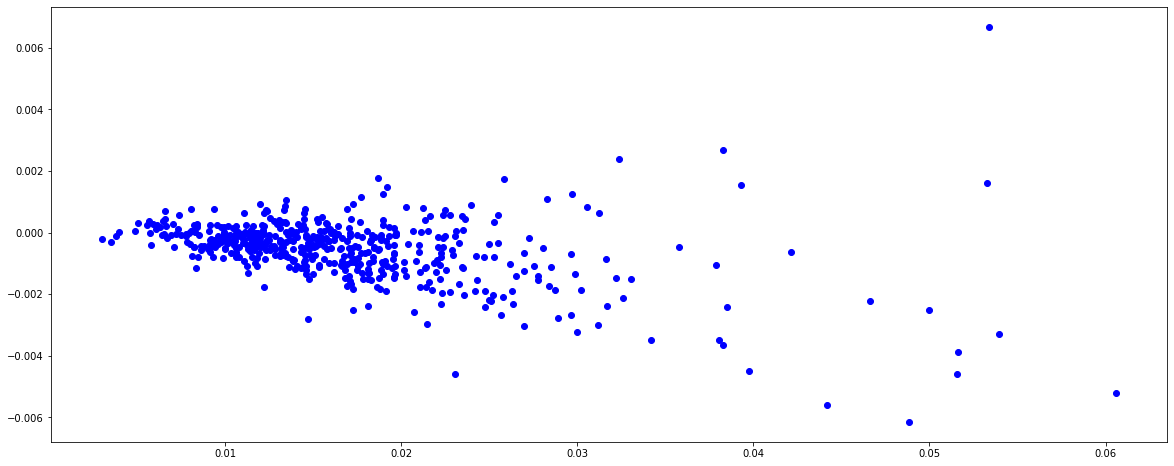

In [12]:
fig, ax = plt.subplots()

ax.scatter(stats['Standard deviation'], stats['Expected returns'], c = 'blue')
fig.set_figwidth(20)     
fig.set_figheight(8)    

plt.show()

## Задание 3

### Построение портфеля с равными долями

In [13]:
N = len(tickers)
part = 1/N
expected_return_knapsack = 0
for i in range(N):
  expected_return_knapsack += stats['Expected returns'][i] * part

expected_return_knapsack

-0.0005483837221510842

### Мат ожидание и ст. отклонение

In [14]:
returns_eqw = []
for index, row in log_returns.iterrows():
    returns_eqw.append(np.sum(row)/len(tickers))

In [15]:
deviation_knapsack = 0
for i in range(N-1):
  for j in range(1, N):
    deviation_knapsack += part**2 * np.cov(log_returns[tickers[i]].astype('float32'), log_returns[tickers[j]].astype('float32'))[0][1]

deviation_knapsack = math.sqrt(deviation_knapsack)
deviation_knapsack

0.006315911136468486

### Отображение на карте активов

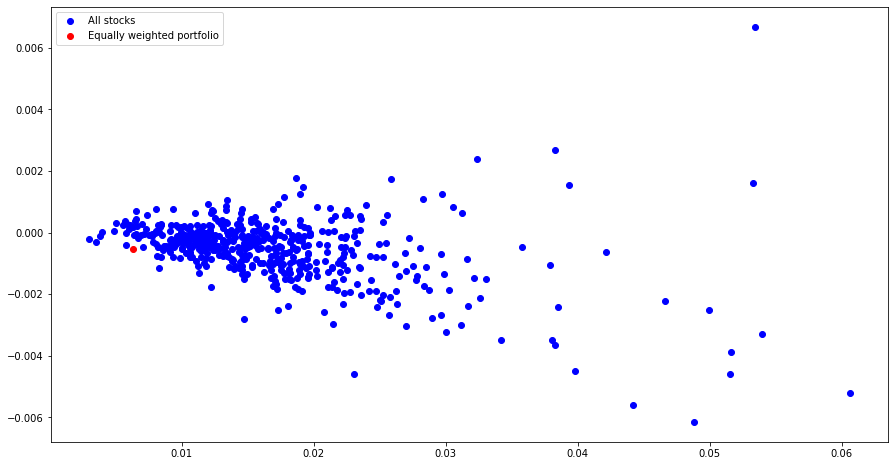

In [16]:
fig, ax = plt.subplots()

ax.scatter(stats['Standard deviation'], stats['Expected returns'], label='All stoсks', c = 'blue')
plt.scatter(deviation_knapsack, expected_return_knapsack, color="red", label='Equally weighted portfolio')
fig.set_figwidth(15)     
fig.set_figheight(8)    
plt.legend()
plt.show()

## Задание 4



### Данные по индексу рынка

In [17]:
market_index = yf.download('^FTSE', start=start, end=end, progress=False)
market_index['Name'] = '^FTSE'
market_index

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2018-01-02 00:00:00+00:00,7687.799805,7691.299805,7624.100098,7648.100098,7648.100098,576251800,^FTSE
2018-01-03 00:00:00+00:00,7648.100098,7689.899902,7640.500000,7671.100098,7671.100098,571662800,^FTSE
2018-01-04 00:00:00+00:00,7671.100098,7702.500000,7671.100098,7695.899902,7695.899902,705864000,^FTSE
2018-01-05 00:00:00+00:00,7695.899902,7727.700195,7689.799805,7724.200195,7724.200195,636035700,^FTSE
2018-01-08 00:00:00+00:00,7724.200195,7733.399902,7691.799805,7696.500000,7696.500000,635135400,^FTSE
...,...,...,...,...,...,...,...
2018-12-20 00:00:00+00:00,6765.899902,6765.899902,6646.500000,6711.899902,6711.899902,903273100,^FTSE
2018-12-21 00:00:00+00:00,6711.899902,6733.000000,6653.700195,6721.200195,6721.200195,1596669300,^FTSE
2018-12-24 00:00:00+00:00,6721.200195,6721.200195,6661.000000,6686.000000,6686.000000,192808000,^FTSE


In [18]:
market_index_edited = market_index.drop(columns = ['Low', 'High', 'Open', 'Close', 'Volume'])
market_index_edited
#market_index_edited.set_index(['Date'])

index_data = (market_index.assign(idx=market_index.groupby('Name').cumcount())
                 .pivot_table(index='Date', columns='Name', 
                              values='Adj Close', aggfunc='sum'))
index_data

Name,^FTSE
Date,
2018-01-02 00:00:00+00:00,7648.100098
2018-01-03 00:00:00+00:00,7671.100098
2018-01-04 00:00:00+00:00,7695.899902
2018-01-05 00:00:00+00:00,7724.200195
2018-01-08 00:00:00+00:00,7696.500000
...,...
2018-12-20 00:00:00+00:00,6711.899902
2018-12-21 00:00:00+00:00,6721.200195
2018-12-24 00:00:00+00:00,6686.000000


### Мат. ожидание и ст. отклонение

In [19]:
index_log_return = np.log(index_data['^FTSE'] / index_data['^FTSE'].shift(1))
index_log_return.drop(["2018-01-02 00:00:00+00:00"], inplace=True)
index_mean = index_log_return.mean()
index_deviation = index_log_return.std()
print(index_mean,'\n\n', index_deviation)

-0.0005071232789132974 

 0.008037053981426312


### Отображение на карте активов

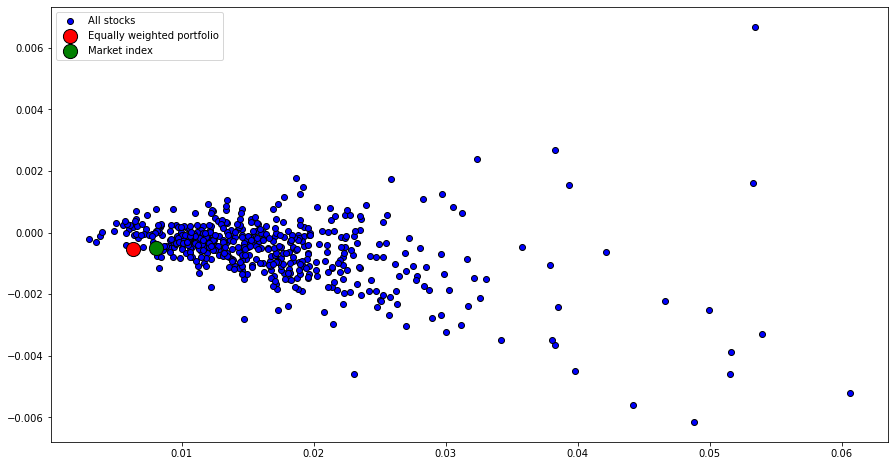

In [20]:
fig, ax = plt.subplots()

ax.scatter(stats['Standard deviation'], stats['Expected returns'], label='All stoсks', c = 'blue', edgecolor = 'black')
p = plt.scatter(deviation_knapsack, expected_return_knapsack, color="red",edgecolor = 'black', label='Equally weighted portfolio')
m = plt.scatter(index_deviation, index_mean, color="green", edgecolor = 'black', label='Market index')
s = np.array([200])
m.set_sizes(s)
p.set_sizes(s)
fig.set_figwidth(15)     
fig.set_figheight(8)    
plt.legend()
plt.show()

## Задание 5

### VaR для активов

In [48]:
losses = -log_returns

losses_eqw = [-x for x in returns_eqw] # losses for equally weighted portfolio

VaR1 = np.quantile(losses, q=1-0.90, axis=0)
VaR1 = pd.DataFrame(columns = tickers, data=[VaR1])

VaR2 = np.quantile(losses, q=1-0.95, axis=0)
VaR2 = pd.DataFrame(columns = tickers, data=[VaR2])

In [49]:
print("VaR для всех активов при γ = 0.9")
VaR1

VaR для всех активов при γ = 0.9


,3IN,888,AAIF,AAL,AAS,ABD,ABDN,ABF,ADIG,ADM,...,WIN,WIZZ,WKP,WPP,WTAN,WTB,WWH,XAR,XPP,ZTF
0,-0.010123,-0.016297,-0.013637,-0.029578,-0.01005,-0.012685,-0.015804,-0.01533,-0.012321,-0.014769,...,-0.021455,-0.026013,-0.015406,-0.021754,-0.009497,-0.014262,-0.014568,-0.0284,-0.019109,-0.021583


In [50]:
print("VaR для всех активов при γ = 0.95")
VaR2

VaR для всех активов при γ = 0.95


,3IN,888,AAIF,AAL,AAS,ABD,ABDN,ABF,ADIG,ADM,...,WIN,WIZZ,WKP,WPP,WTAN,WTB,WWH,XAR,XPP,ZTF
0,-0.013783,-0.021883,-0.015504,-0.034557,-0.014815,-0.017279,-0.022725,-0.021821,-0.016129,-0.018004,...,-0.031115,-0.034249,-0.022282,-0.027644,-0.011941,-0.017882,-0.019623,-0.039817,-0.026465,-0.032048


In [51]:
print(f"При γ = 0.9 наиболее предпочтительными являются активы: \n  VaR={VaR1.loc[0].sort_values()[:5]}\n\n")
print(f"При γ = 0.95 наиболее предпочтительными являются активы: \n  VaR={VaR2.loc[0].sort_values()[:5]}")

При γ = 0.9 наиболее предпочтительными являются активы: 
  VaR=LUCE   -0.047776
ENQ    -0.043394
CPI    -0.041448
KNOS   -0.038409
RCH    -0.037201
Name: 0, dtype: float64


При γ = 0.95 наиболее предпочтительными являются активы: 
  VaR=LUCE   -0.067270
NANO   -0.061736
ENQ    -0.061327
CPI    -0.057163
OXB    -0.053657
Name: 0, dtype: float64


Заметим, что самый предпочтительный актив в обоих случаях - это акция с тикером OIG - Oryx International Growth Fund Limited (Инвестиционный фонд)
Также себя хорошо показывают:
- EnQuest PLC - Независимая компания по разведке и добыче нефти
- британская нанотехнологическая компания Nanoco
- Kainos Group plc - Компания-разработчик программного обеспечения

### VaR для портфеля с равными долями

In [25]:
VaR_p = np.quantile(losses_eqw, q=0.90)
print(f"При γ = 0.9 VaR портфеля с равными долями составляет {VaR_p}")

VaR_p = np.quantile(losses_eqw, q=0.95)
print(f"При γ = 0.95 VaR портфеля с равными долями составляет {VaR_p}")

При γ = 0.9 VaR портфеля с равными долями составляет 0.00846354724354509
При γ = 0.95 VaR портфеля с равными долями составляет 0.011197440753565668


### VaR для индекса

In [26]:
index_losses = -index_log_return

VaR1 = np.quantile(index_losses, q=0.9, axis=0)

VaR2 = np.quantile(index_losses, q=0.95, axis=0)

print(f"При γ = 0.9 VaR индекса FTSE500 составляет {VaR1}")
print(f"При γ = 0.95 VaR индекса FTSE500 составляет {VaR2}") 

При γ = 0.9 VaR индекса FTSE500 составляет 0.011185273314018284
При γ = 0.95 VaR индекса FTSE500 составляет 0.013315135782953562


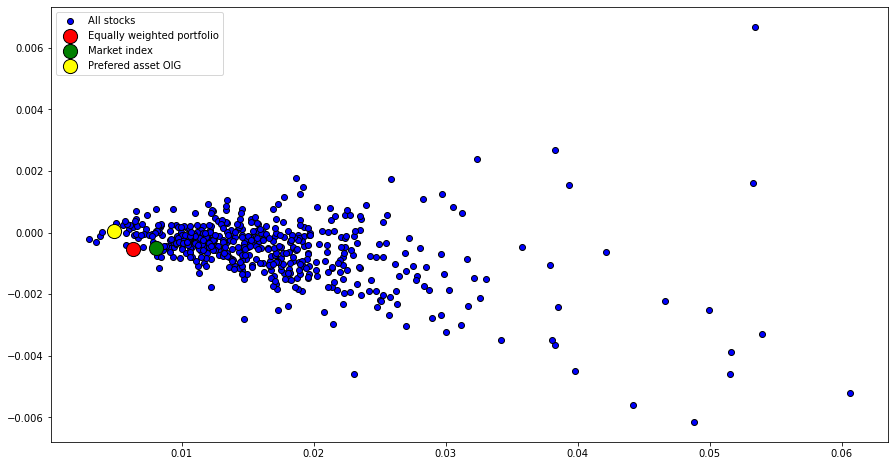

In [27]:
fig, ax = plt.subplots()

ax.scatter(stats['Standard deviation'], stats['Expected returns'], label='All stoсks', c = 'blue', edgecolor = 'black')
p = plt.scatter(deviation_knapsack, expected_return_knapsack, color="red",edgecolor = 'black', label='Equally weighted portfolio')
m = plt.scatter(index_deviation, index_mean, color="green", edgecolor = 'black', label='Market index')
b = plt.scatter(stats['Standard deviation']['OIG'], stats['Expected returns']['OIG'], color="yellow", edgecolor = 'black', label='Prefered asset OIG')
s = np.array([200])
m.set_sizes(s)
p.set_sizes(s)
b.set_sizes(s)
fig.set_figwidth(15)     
fig.set_figheight(8)    
plt.legend()
plt.show()

## Задание 6

Тут будет теория гипотезы случайности и критерий инверсий

###По доходности

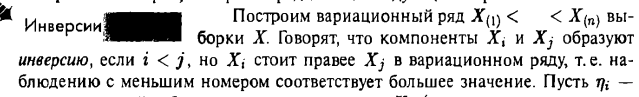

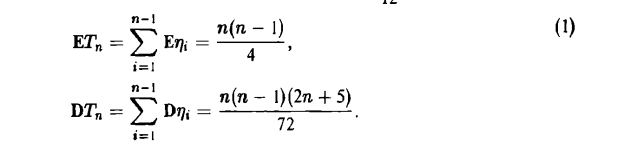

In [28]:
chosen_tickers = ['AZN', 'BP', 'BARC', 'LLOY', 'PRU']
n = log_returns.shape[0]
alpha = 0.01
H_inv = dict.fromkeys(chosen_tickers)
H_corr = dict.fromkeys(chosen_tickers)

In [29]:
for t in chosen_tickers:
    n_inv = 0
    for i in range(n-1):
        for j in range(i+1, n):
            if log_returns[t][i] > log_returns[t][j]:
                n_inv += 1
    
    expected_return_a = n*(n-1)/4
    deviation_a = (n*(2*n + 5)*(n-1)) / 72
    temp = abs(n_inv - expected_return_a) / math.sqrt(deviation_a)

    if temp > scipy.stats.norm.ppf(1 - (alpha/2)):
        H_inv[t] = True
    else: H_inv[t] = False

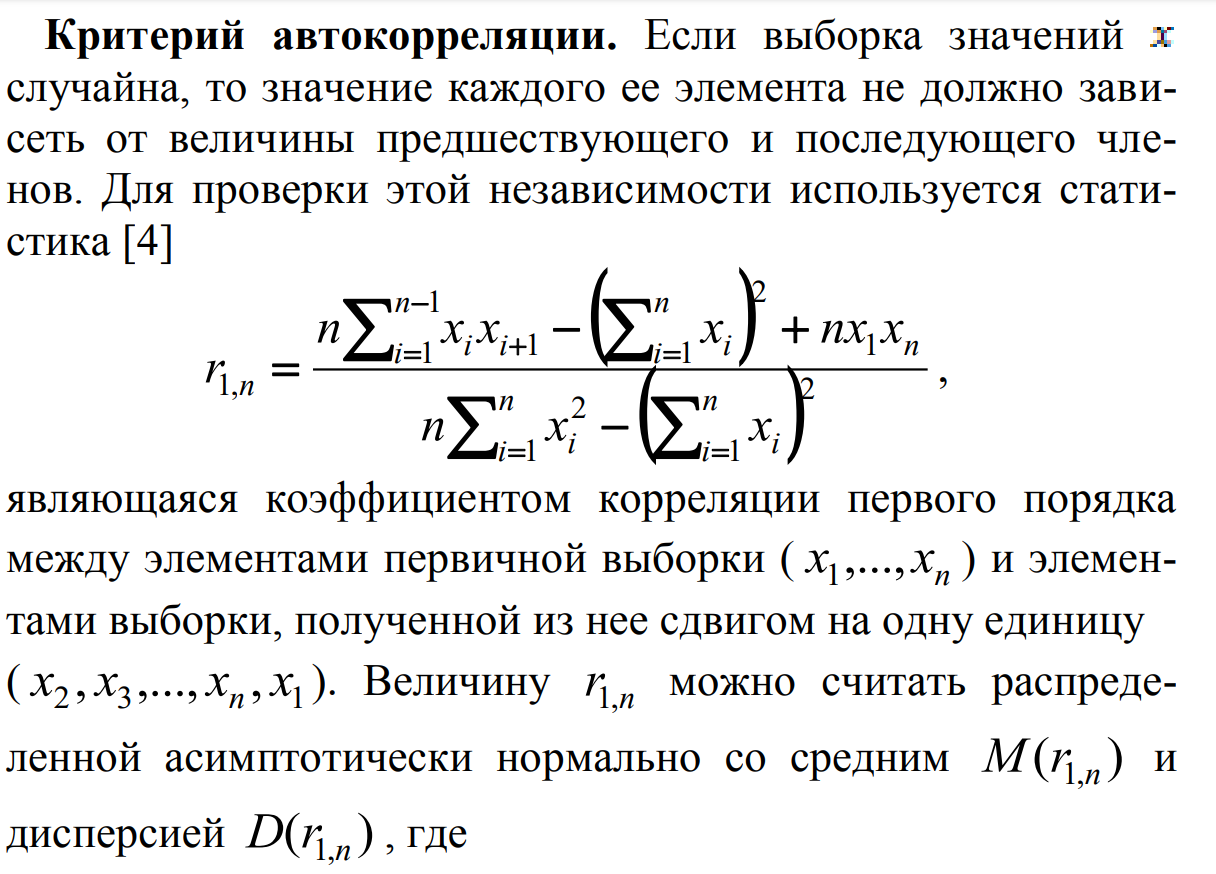

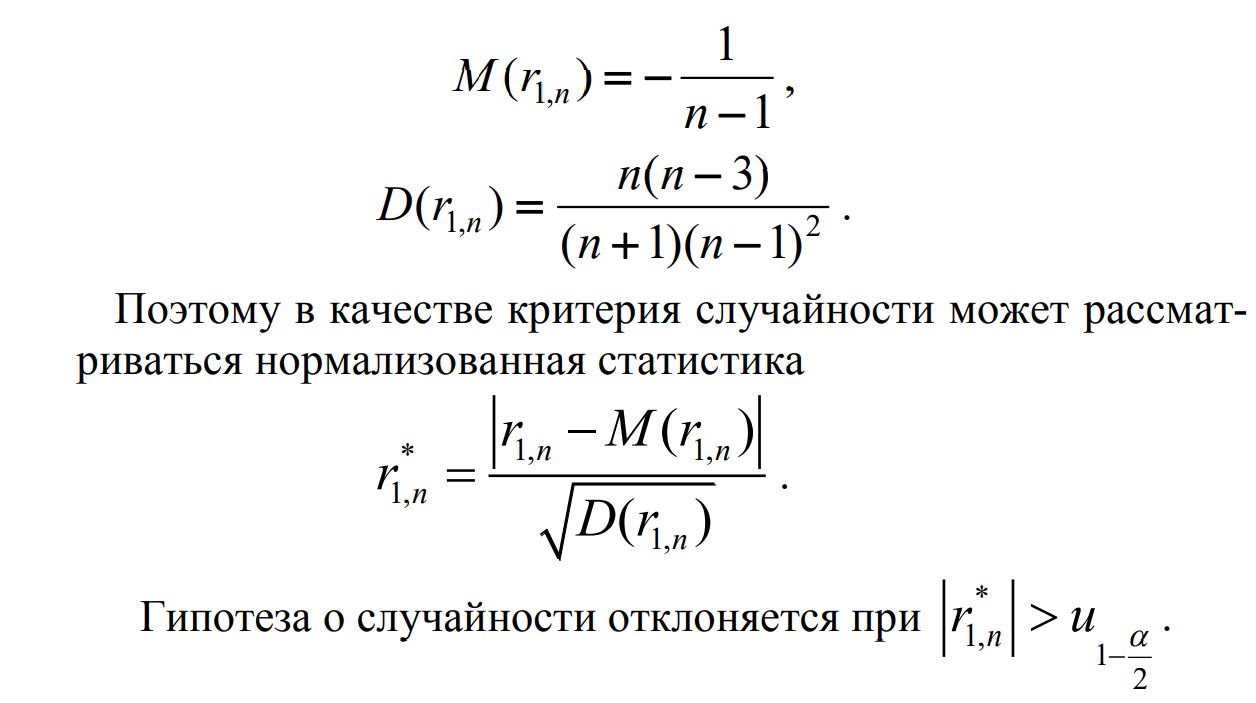

In [30]:
for t in chosen_tickers:
    
    sum_1 = 0 # sum of x_i * x_i+1
    sum_2 = 0 # (sum of x_i) ** 2
    sum_3 = 0 # sum of x_i ** 2

    for i in range(n-1):
        sum_1 += log_returns[t][i] * log_returns[t][i+1]
    for i in range(n):
        sum_2 += log_returns[t][i]
    sum_2 = sum_2 ** 2
    for i in range(n):
        sum_2 += log_returns[t][i] ** 2

    A = (n*sum_1 - sum_2 + n*log_returns[t][0]*log_returns[t][-1]) / (n*sum_3 - sum_2)
    expected_return_a = - 1 / (n-1)
    deviation_a = (n*(n-3)) / ((n+1) * (n-1)**2)
    A_norm = abs(A - expected_return_a) / math.sqrt(deviation_a)
    if A_norm > scipy.stats.norm.ppf(1 - (alpha/2)):
        H_corr[t] = True
    else: H_corr[t] = False

In [31]:
for t in chosen_tickers:
    print(f'Ticker {t}: ')
    if H_inv[t]:
        print(f"Гипотеза H_0 подтверджается согласно критерию инверсий")
    else:
        print(f"Гипотеза H_0 отвергается согласно критерию инверсий")
    if H_corr[t]:
        print(f"Гипотеза H_0 подтверджается согласно критерию автокорреляции")
    else:
        print(f"Гипотеза H_0 отвергается согласно критерию автокорреляции")
    print('')

Ticker AZN: 
Гипотеза H_0 отвергается согласно критерию инверсий
Гипотеза H_0 подтверджается согласно критерию автокорреляции

Ticker BP: 
Гипотеза H_0 отвергается согласно критерию инверсий
Гипотеза H_0 подтверджается согласно критерию автокорреляции

Ticker BARC: 
Гипотеза H_0 отвергается согласно критерию инверсий
Гипотеза H_0 подтверджается согласно критерию автокорреляции

Ticker LLOY: 
Гипотеза H_0 отвергается согласно критерию инверсий
Гипотеза H_0 подтверджается согласно критерию автокорреляции

Ticker PRU: 
Гипотеза H_0 отвергается согласно критерию инверсий
Гипотеза H_0 подтверджается согласно критерию автокорреляции



### По объему

In [32]:
chosen_tickers = ['AZN', 'BP', 'BARC', 'LLOY', 'PRU']
n = log_returns.shape[0]
alpha = 0.01
H_inv = dict.fromkeys(chosen_tickers)
H_corr = dict.fromkeys(chosen_tickers)

In [33]:
for t in chosen_tickers:
    n_inv = 0
    for i in range(n-1):
        for j in range(i+1, n):
            if volume_data[t][i] > volume_data[t][j]:
                n_inv += 1
    
    expected_return_a = n*(n-1)/4
    deviation_a = (n*(2*n + 5)*(n-1)) / 72
    temp = abs(n_inv - expected_return_a) / math.sqrt(deviation_a)

    if temp > scipy.stats.norm.ppf(1 - (alpha/2)):
        H_inv[t] = True
    else: H_inv[t] = False


for t in chosen_tickers:
    
    sum_1 = 0 # sum of x_i * x_i+1
    sum_2 = 0 # (sum of x_i) ** 2
    sum_3 = 0 # sum of x_i ** 2

    for i in range(n-1):
        sum_1 += volume_data[t][i] * volume_data[t][i+1]
    for i in range(n):
        sum_2 += volume_data[t][i]
    sum_2 = sum_2 ** 2
    for i in range(n):
        sum_2 += volume_data[t][i] ** 2

    A = (n*sum_1 - sum_2 + n*volume_data[t][0]*volume_data[t][-1]) / (n*sum_3 - sum_2)
    expected_return_a = - 1 / (n-1)
    deviation_a = (n*(n-3)) / ((n+1) * (n-1)**2)
    A_norm = abs(A - expected_return_a) / math.sqrt(deviation_a)
    if A_norm > scipy.stats.norm.ppf(1 - (alpha/2)):
        H_corr[t] = True
    else: H_corr[t] = False

In [34]:
for t in chosen_tickers:
    print(f'Ticker {t}: ')
    if H_inv[t]:
        print(f"Гипотеза H_0 подтверджается согласно критерию инверсий")
    else:
        print(f"Гипотеза H_0 отвергается согласно критерию инверсий")
    if H_corr[t]:
        print(f"Гипотеза H_0 подтверджается согласно критерию автокорреляции")
    else:
        print(f"Гипотеза H_0 отвергается согласно критерию автокорреляции")
    print('')

Ticker AZN: 
Гипотеза H_0 отвергается согласно критерию инверсий
Гипотеза H_0 отвергается согласно критерию автокорреляции

Ticker BP: 
Гипотеза H_0 отвергается согласно критерию инверсий
Гипотеза H_0 отвергается согласно критерию автокорреляции

Ticker BARC: 
Гипотеза H_0 отвергается согласно критерию инверсий
Гипотеза H_0 отвергается согласно критерию автокорреляции

Ticker LLOY: 
Гипотеза H_0 отвергается согласно критерию инверсий
Гипотеза H_0 отвергается согласно критерию автокорреляции

Ticker PRU: 
Гипотеза H_0 подтверджается согласно критерию инверсий
Гипотеза H_0 отвергается согласно критерию автокорреляции



## Задание 7

Для этого задания мы взяли те же активы что и в прошлом, т.к. они находятся в разных производственных секторах: 'LGEN', 'AZN', 'BP', 'BARC' 
 - (LGEN.L) Legal & General Group Plc - Страхование
 - (AZN.L) AstraZeneca PLC - Фармацевтика
 - (BP.L) BP p.l.c. - Топливо
 - (BARC.L) Barclays PLC - Финансы

### Графики

Для начала посмотрим на графическую интерпритацию распределения доходностей:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


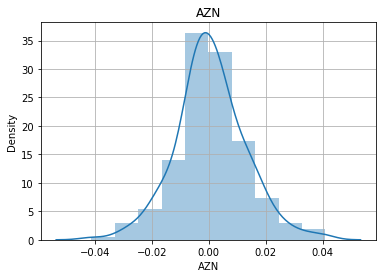

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


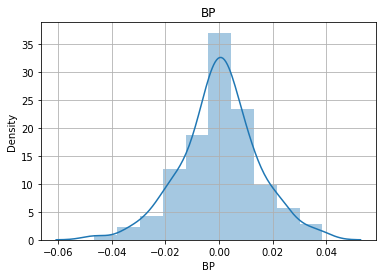

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


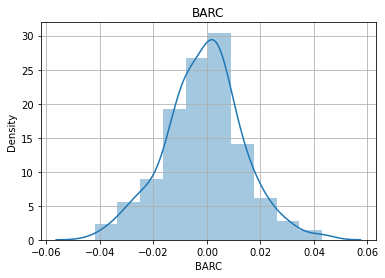

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


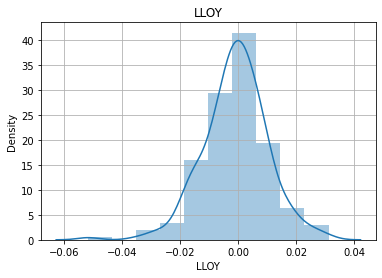

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


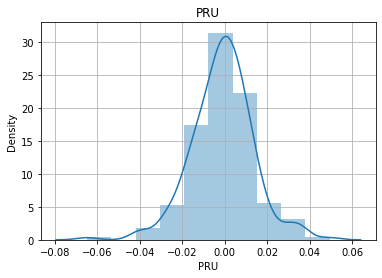

In [37]:
def plot_vs_pdf(labels):
    for label in labels:
        plt.grid()
        sns.distplot(log_returns[label], bins=10)
        plt.title(label)
        plt.show()
plot_vs_pdf(chosen_tickers)

### Тесты проверки гипотез

Однозначный вывод насчет нормального распределения сделать не получается, поэтому построим тесты проверки гипотез Шапиро-Вилка, Д'Агостино, Андерсона-Дарлинга

In [39]:
tests = {"Shapiro-test" : shapiro, 
         "D'Agostino-test" : normaltest, 
         "Anderson-test" : anderson, }
        
params = {'По доходностям' : log_returns, 'По объемам' : volume_data}
alpha = 0.05
start = "\033[1m"
end = "\033[0;0m"

for p_name, p_val in params.items():
    print(f'{p_name}: ')
    for ticker in chosen_tickers:
        print(ticker, ': ')
        for test_name, test_f in tests.items():
            result = test_f(p_val[ticker])
            if test_name == 'Anderson-test':
                statistic = result[0]
                answer = 'отвергается' if statistic > result[1][2] else 'не отвергается'
                print("\t Гипотеза {} {} {} {}, статистика={:3f}".format(start, answer, end, test_name, statistic))
            else:
                p_value = result[1]
                answer = 'не отвергается' if p_value > alpha else 'отвергается'
                print("\t Гипотеза {} {} {} {}, p-value={:3f}".format(start, answer, end, test_name,  p_value))

По доходностям: 
AZN : 
	 Гипотеза  отвергается  Shapiro-test, p-value=0.033203
	 Гипотеза  отвергается  D'Agostino-test, p-value=0.036187
	 Гипотеза  отвергается  Anderson-test, статистика=1.037082
BP : 
	 Гипотеза  отвергается  Shapiro-test, p-value=0.036590
	 Гипотеза  не отвергается  D'Agostino-test, p-value=0.084594
	 Гипотеза  отвергается  Anderson-test, статистика=1.072600
BARC : 
	 Гипотеза  не отвергается  Shapiro-test, p-value=0.232092
	 Гипотеза  не отвергается  D'Agostino-test, p-value=0.386625
	 Гипотеза  не отвергается  Anderson-test, статистика=0.664241
LLOY : 
	 Гипотеза  отвергается  Shapiro-test, p-value=0.002310
	 Гипотеза  отвергается  D'Agostino-test, p-value=0.000108
	 Гипотеза  отвергается  Anderson-test, статистика=0.899368
PRU : 
	 Гипотеза  отвергается  Shapiro-test, p-value=0.000321
	 Гипотеза  отвергается  D'Agostino-test, p-value=0.000404
	 Гипотеза  отвергается  Anderson-test, статистика=1.369353
По объемам: 
AZN : 
	 Гипотеза  отвергается  Shapiro-test, p

### Выводы

В соответствии с тестами проверки гипотез, мы можем сделать вывод, что актив (BARC.L) Barclays PLC распределен нормально по доходностям с уровнем значимости 0.05. Также гипотеза о нормальности по доходностям не отвергается по тесту Да'Гостино у актива (BP.L) BP p.l.c.

Что касается распределения объемов продаж, то по всем тестам проверки гипотез все выбранные активы **не** распределены нормально.

##Задание 8

In [40]:
def plot_correlations(company1, ticker1, company2, ticker2):
    plt.scatter(company1, company2, c = 'green')
    plt.xlabel(ticker1)
    plt.ylabel(ticker2)
    plt.show()
    print('Коэффициент корреляции: ' , np.corrcoef(company1.astype(float), company2.astype(float))[1][0])

###BP, SHEL(shell) - две компании из нефтяной отрасли


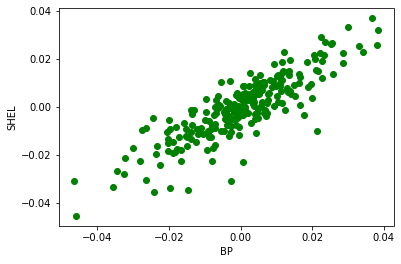

Коэффициент корреляции:  0.8560231043974363


In [41]:
plot_correlations(log_returns['BP'], 'BP', log_returns['SHEL'], 'SHEL')

###BARC, LLOY - финансовая отрасль

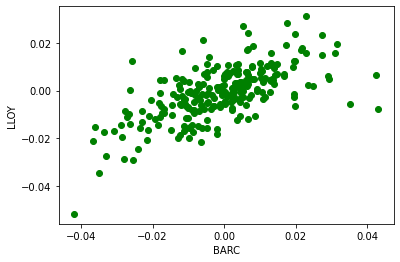

Коэффициент корреляции:  0.6454155878026571


In [42]:
plot_correlations(log_returns['BARC'], 'BARC', log_returns['LLOY'], 'LLOY')

###BARC, PRU - финансовая отрасль

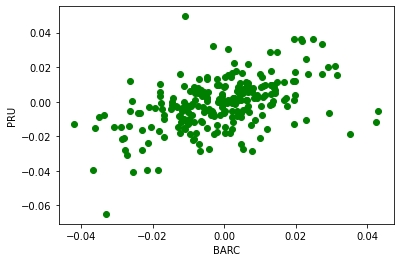

Коэффициент корреляции:  0.4838324602257257


In [43]:
plot_correlations(log_returns['BARC'], 'BARC', log_returns['PRU'], 'PRU')

Компании нефтегазовой отрасли имеют высокую корреляцию, так как оба зависят от цен на ресурсы. Финансовой отрасли имеют корреляцию чуть ниже, так как ни от каких подобных, сильно влияющих на их доходы, параметров не зависят.

### BP, EAG (International Airlines Group) - нефтяная и авиационная отрасли соответственно

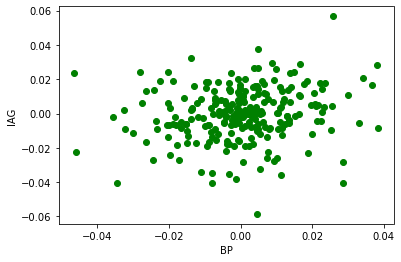

Коэффициент корреляции:  0.15807683083942775


In [44]:
plot_correlations(log_returns['BP'], 'BP', log_returns['IAG'], 'IAG')

Зависимость между активами из разных отраслей минимальна. Можно предположить, что они зависят друг от друга в небольшой степени, потому что расположены в одном государстве, следовательно, находятся в одном информационном фоне, подчиняются одним законам, а также все действия государства, так или иначе влияющие на экономику страны, влияют на все комании в ней.

###Объем продаж от доходности

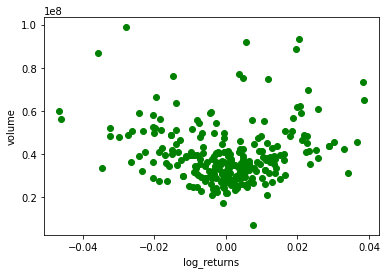

Коэффициент корреляции:  -0.022562404520827407


In [45]:
plot_correlations(log_returns['BP'], 'log_returns', volume_data['BP'], 'volume')

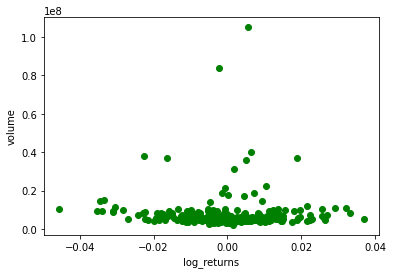

Коэффициент корреляции:  -0.02117890031461548


In [46]:
plot_correlations(log_returns['SHEL'], 'log_returns', volume_data['SHEL'], 'volume')

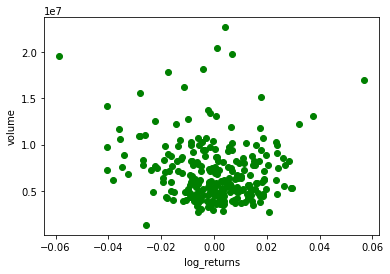

Коэффициент корреляции:  -0.12502659531307347


In [47]:
plot_correlations(log_returns['IAG'], 'log_returns', volume_data['IAG'], 'volume')

Корреляция между доходностью и объемом продаж очень близка к нулю, однако по этим графикам можно заметить, что разброс доходности при увеличении объема продаж становится выше (за исключением компании Shell), что, в принципе, логично (так как при нулевом объеме продаж цена остаётся прежней)